# Part 5 - Random Forest Regressor & Optimization <a class="anchor" id="top"></a>
Previously, we have compared the basic model performance of 5 established regressor models and basic Random Forest Regressor has emerged to produce the highest accuracy. We will now perform optimization on the random forest regressor model to further improve its accuracy. We will introduce 6 different optimization strategies which are further elaborated in sections 4 - 9. <br>

**Overview of Implementation**
1. <a href="#section1">Import Dataset</a>
2. <a href="#section2">Cleaning the Data for Model Training</a>
3. <a href="#section3">Random Tree Regressor</a>
4. <a href="#section4">Feature Importance and Selection</a>
5. <a href="#section5">Reducing Skewness in Continuous Variables</a>
6. <a href="#section6">Reducing Skewness in Categorical Variables</a>
7. <a href="#section7">Data Scaling</a>
8. <a href="#section8">Hyperparameter Tuning</a>
9. <a href="#section9">Further Data Engineering</a>
10. <a href="#section10">Result Compilation</a>

**Github Link**: https://github.com/leakin185/CE9010Project

In [976]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics
from scipy import stats
import researchpy as rp
import math
from scipy.stats import skew 
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statistics import mean, median, mode, stdev
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from feature_engine.discretisation import EqualWidthDiscretiser
from feature_engine.imputation import MeanMedianImputer
from feature_engine.imputation import CategoricalImputer
import collections

## <a id='section1'>1. Import Dataset</a>

In [919]:
train = pd.read_csv('train.csv')
train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


## <a id='section2'>2. Cleaning the Data for Model Training</a>
Remove the NA data and perform One Hot Encoding

### 2.1. Removing the Null Data

In [920]:
nullData = [['LotFrontage', 259], ['MasVnrArea', 8], ['Electrical', 1], ['GarageYrBlt', 81]]
n = len(train)
treshold = 0.1
drop = []

print('Drop feature - too many nulls:')
for i in nullData:
    if i[1]/n > treshold: # Arbitrary treshold: 10%
        print(i[0])
        train.drop(columns=[i[0]], inplace=True)
    else:
        drop.append(i[0])
        
print('Remove data point:')
print(drop)
train.dropna(subset=drop, inplace=True)

train

Drop feature - too many nulls:
LotFrontage
Remove data point:
['MasVnrArea', 'Electrical', 'GarageYrBlt']


,Id,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


### 2.2. One-Hot Encoding

In [921]:
#One-Hot encoding
categoricalcolumns = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond','Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
train1 = pd.get_dummies(train, columns= categoricalcolumns, prefix= categoricalcolumns)
print(train1)

        Id  LotArea  YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  \
0        1     8450       2003          2003       196.0         706   
1        2     9600       1976          1976         0.0         978   
2        3    11250       2001          2002       162.0         486   
3        4     9550       1915          1970         0.0         216   
4        5    14260       2000          2000       350.0         655   
...    ...      ...        ...           ...         ...         ...   
1455  1456     7917       1999          2000         0.0           0   
1456  1457    13175       1978          1988       119.0         790   
1457  1458     9042       1941          2006         0.0         275   
1458  1459     9717       1950          1996         0.0          49   
1459  1460     9937       1965          1965         0.0         830   

      BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  ...  SaleType_ConLw  \
0              0        150          856       856  ...     

[back to top](#top)

## <a id='section3'>3. Random Tree Regressor</a>
This model can be used for both classification and regression, and is built on top of the Decision Tree method. It works by randomly selecting data subsets, creating decision trees on each subset, and then vote for the best solution. The more trees there are in the forest, the more robust the model. 
In this case, our predictive or dependent variable is the SalePrice.

We first employ a random forest regressor with default parameters.

In [308]:
#train-test split
TEST_SIZE = 0.25

filteredData1 = train1.drop(['Id'], axis=1)
train_df, test_df = train_test_split(filteredData1, test_size=TEST_SIZE,shuffle = False) #put shuffle = False so that we can reuse the same training and test sets for better comparison

train_X = train_df.drop('SalePrice', axis=1)
train_Y = train_df['SalePrice']
test_X = test_df.drop('SalePrice', axis=1)
test_Y = test_df['SalePrice']

In [309]:
regressor = RandomForestRegressor(n_estimators = 5, random_state = 0)
model = regressor.fit(train_X, train_Y)
y_pred = model.predict(test_X)
train_accuracy = model.score(train_X,train_Y)
test_accuracy = model.score(test_X,test_Y)
print ("Train accuracy =", model.score(train_X,train_Y))
print ("Test accuracy =", model.score(test_X,test_Y))

Train accuracy = 0.9507081267362882
Test accuracy = 0.8115182777864649


In [310]:
#comparing the actual and the predicted SalePrice values
df = pd.DataFrame({'Real Values':test_Y, 'Predicted Values':y_pred.reshape(-1)})
df

,Real Values,Predicted Values
1093,146000,142810.0
1094,129000,118300.0
1095,176432,186598.2
1097,170000,153460.0
1098,128000,107001.6
...,...,...
1455,175000,176593.0
1456,210000,198800.0
1457,266500,246700.0
1458,142125,160680.0


In [311]:
#Accuracy report
realVals = df["Real Values"]
predictedVals = df["Predicted Values"]
mse = mean_squared_error(realVals, predictedVals)
rmse = math.sqrt(mse)
print ("Mean square error (MSE) = ", mse)
print ("Root mean square error (RMSE) = ", rmse)
average_y = mean(realVals)
mbs = mean_absolute_error(realVals, predictedVals)
print("Mean absolute error (MBS) = ", mbs)
print ("The MBS occupies ",(mbs/average_y), " of the average SalePrice value")

Mean square error (MSE) =  1111456094.4083965
Root mean square error (RMSE) =  33338.50768118448
Mean absolute error (MBS) =  21267.98717201166
The MBS occupies  0.11622029403628305  of the average SalePrice value


[back to top](#top)

## <a id='section4'>4. Feature Importance and Selection</a>
Feature importance is calculated as the decrease in node impurity weighted by the probability of reaching that node. The node probability can be calculated by the number of samples that reach the node, divided by the total number of samples. The higher the value the more important the feature. We can use this method to select the top most important variables and tune the model based on them.

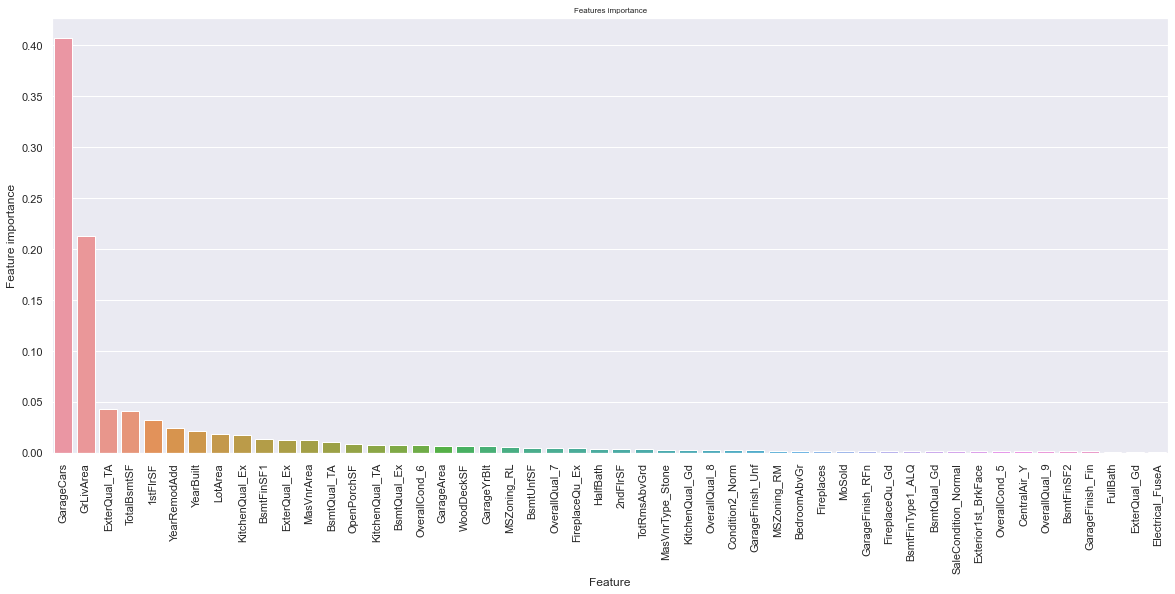

In [346]:
#model optimisation - feature importance
tmp = pd.DataFrame({'Feature': train_X.columns, 'Feature importance': model.feature_importances_})
tmp1 = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (20,8))
plt.title('Features importance',fontsize=8)
s = sb.barplot(x='Feature',y='Feature importance',data=tmp1[:50])
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

In [347]:
#List of features sorted from most to least important
sorted_importances = pd.DataFrame(tmp1['Feature importance'])
sorted_features = pd.DataFrame(tmp1['Feature'])
print(sorted_importances)
print(sorted_features)

     Feature importance
21             0.406469
11             0.212503
197            0.042671
7              0.040760
8              0.031489
..                  ...
102            0.000000
104            0.000000
106            0.000000
107            0.000000
227            0.000000

[314 rows x 1 columns]
              Feature
21         GarageCars
11          GrLivArea
197      ExterQual_TA
7         TotalBsmtSF
8            1stFlrSF
..                ...
102   Condition1_PosA
104   Condition1_RRAe
106   Condition1_RRNe
107   Condition1_RRNn
227  BsmtFinType2_BLQ

[314 rows x 1 columns]


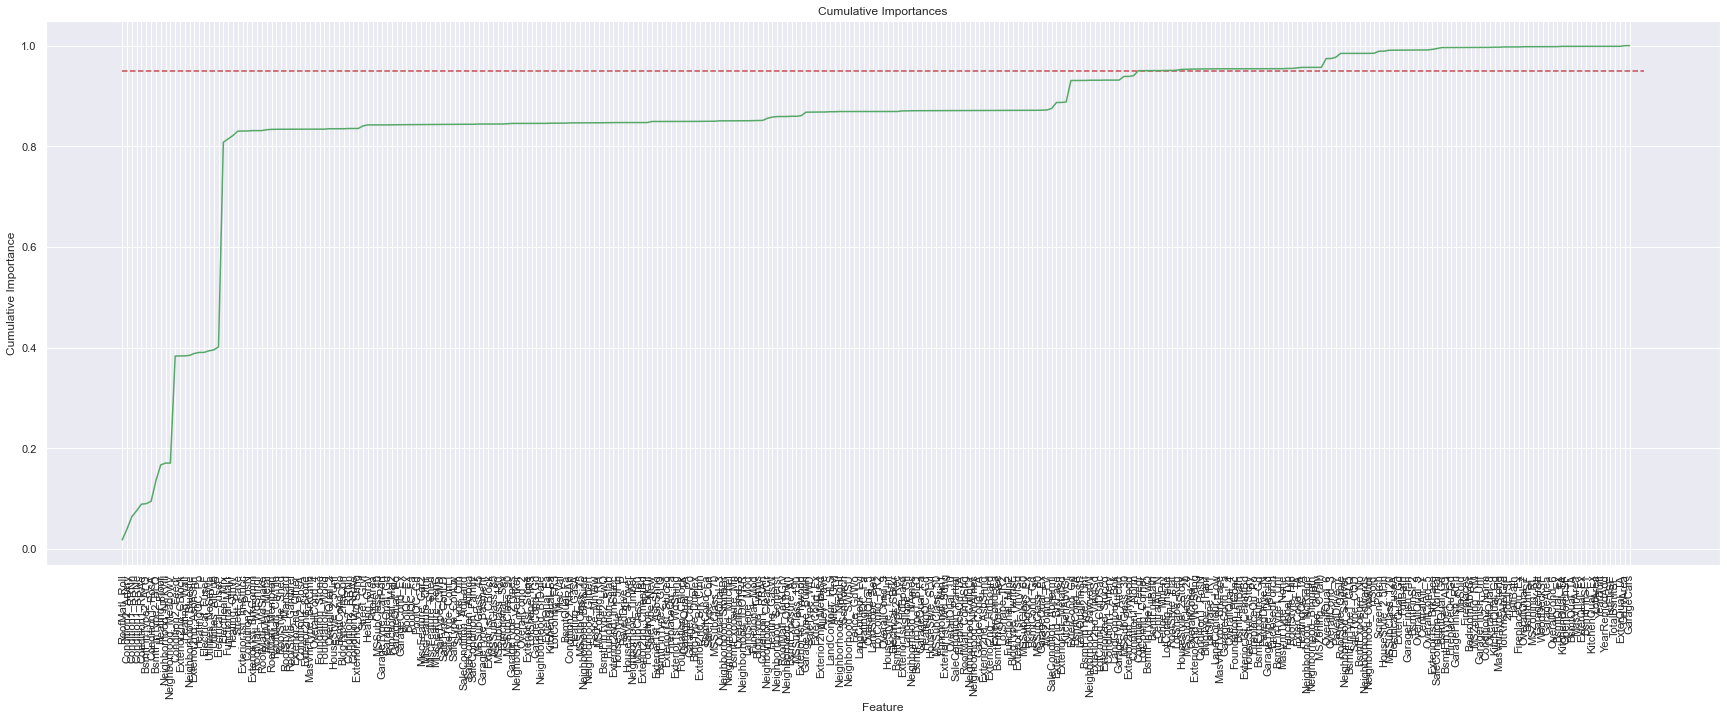

In [319]:
importance = model.feature_importances_

featurelist = []
for c in train_X.columns:
    featurelist.append(c)

indices = np.argsort(importance)
cumulativeimpt= np.cumsum(importance)
featurerank = [featurelist[i] for i in indices]


plt.figure(figsize=(30,10))
plt.plot(featurerank, cumulativeimpt, 'g-')
plt.xticks(featurerank, rotation = 'vertical')
plt.xlabel('Feature')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Importances')

plt.hlines(y = 0.95, xmin=0, xmax=train1.shape[1], color = 'r', linestyles = 'dashed')

In [382]:
countimpt = 0
for i in cumulativeimpt:
    if i >= 0.95:
        countimpt += 1
    
print('Number of features for 95% importance:', countimpt)

Number of features for 95% importance: 103


In [383]:
# Extract the names of the most important features
important_feature_names = sorted_features[0:countimpt]
print (important_feature_names)

              Feature
21         GarageCars
11          GrLivArea
197      ExterQual_TA
7         TotalBsmtSF
8            1stFlrSF
..                ...
243      CentralAir_N
12       BsmtFullBath
223  BsmtFinType1_LwQ
66   LotConfig_Corner
100  Condition1_Feedr

[103 rows x 1 columns]


In [384]:
list1 = []
for i in sorted_features[0:countimpt]["Feature"]:
    list1.append(i)

In [385]:
#use the top 106 variables for regression model training
train_X_new = train_X[list1]
test_X_new = test_X[list1]

In [386]:
#Accuracy after feature selection
regressor = RandomForestRegressor(n_estimators = 10, random_state = 0)
model = regressor.fit(train_X_new, train_Y)
y_pred = model.predict(test_X_new)
train_accuracy_new = model.score(train_X_new,train_Y)
test_accuracy_new = model.score(test_X_new,test_Y)
print ("Train accuracy =", model.score(train_X_new,train_Y))
print ("Test accuracy =", model.score(test_X_new,test_Y))

Train accuracy = 0.9614500225110464
Test accuracy = 0.8706675199366407


In [387]:
mse = mean_squared_error(test_Y, y_pred)
mse

762659484.8731195

In [388]:
#improvement in accuracy
train_improvement = (train_accuracy_new - train_accuracy)/train_accuracy*100
test_improvement = (test_accuracy_new - test_accuracy)/test_accuracy*100
print ("Train accuracy improvement =", train_improvement,"%")
print ("Test accuracy improvement =", test_improvement,"%")

Train accuracy improvement = 1.1298836596289856 %
Test accuracy improvement = 7.288713485482304 %


We can see that the test accuracy has improved with feature selection

[back to top](#top)

## <a id='section5'>5. Data Transformation - Reducing Skewness in Continuous Variables</a>
1. **Log Transformation** <br>
Log transformation is a data transformation method in which it replaces each variable x with a log(x). When our original continuous data do not follow the bell curve, we can log transform this data to make it as “normal” as possible so that the statistical analysis results from this data become more valid. In other words, the log transformation reduces or removes the skewness of our original data

2. **Removing outliers with IQR** <br>
The Interquartile Range (IQR) is a measure of variability, based on dividing a data set into quartiles. Quartiles divide a rank-ordered data set into four equal parts. As we remove outliers with IQR, we are trying to reduce the skewness in variables.

In [389]:
# identifying continuous variables with high skewness
continuous = ['LotArea', 'YearBuilt', 'YearRemodAdd', 
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr','TotRmsAbvGrd', 'Fireplaces', 
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
array1 = skew(train1[continuous])
#the top 15 features which are the most skewed
index1 = array1.argsort()[-15:][::-1]
continuous_skewed=[]
for i in index1:
    print (continuous[i],": skewness = ", array1[i])
    if array1[i]>=1:
        continuous_skewed.append(continuous[i])

MiscVal : skewness =  24.732979451706033
PoolArea : skewness =  14.342881566937836
LotArea : skewness =  12.025446327344339
LowQualFinSF : skewness =  10.66505349858299
3SsnPorch : skewness =  9.96262046395852
KitchenAbvGr : skewness =  5.129053439295553
BsmtFinSF2 : skewness =  4.174330005566947
ScreenPorch : skewness =  3.967379533802487
BsmtHalfBath : skewness =  3.89811918894981
EnclosedPorch : skewness =  3.214887613130617
MasVnrArea : skewness =  2.588332838278803
OpenPorchSF : skewness =  2.2638025759950504
BsmtFinSF1 : skewness =  1.6941364533315026
TotalBsmtSF : skewness =  1.6330286577439608
WoodDeckSF : skewness =  1.5027101898713007


In [390]:
#applying log transformation for selected variables
train2=train1.copy()
for i in continuous_skewed:
    train2[i] = train2[i].map(lambda l: np.log(l) if l > 0 else 0)

In [391]:
array2 = skew(train2[continuous])
#the top 15 features which are the most skewed
index2 = array2.argsort()[-15:][::-1]
continuous_skewed=[]
for i in index2: 
    print (continuous[i],": skewness = ", array2[i])
    if array2[i] >= 1:
        continuous_skewed.append(continuous[i])

BsmtHalfBath : skewness =  36.97297297297236
PoolArea : skewness =  13.892471985364587
LowQualFinSF : skewness =  8.537169018827495
3SsnPorch : skewness =  7.475352552864676
MiscVal : skewness =  5.151007848096852
KitchenAbvGr : skewness =  4.960618997125171
ScreenPorch : skewness =  3.0205800205812574
BsmtFinSF2 : skewness =  2.453380237081663
EnclosedPorch : skewness =  2.203145749719571
GrLivArea : skewness =  1.4168971139325073
1stFlrSF : skewness =  1.3857782746124663
BsmtUnfSF : skewness =  0.9266242711949279
GarageArea : skewness =  0.8114489269622572
2ndFlrSF : skewness =  0.7879161526110934
TotRmsAbvGrd : skewness =  0.6758238152091317


From the results, we have seen that the skewness of some variables have been reduced with log transformation, but some did not. This is likely because the original data has to follow or approximately follow a log-normal distribution. Otherwise, the log transformation will not work as well. As such, we will perform log transformation on the variables which have their skewness successfully reduced after log transformation but not the others.

In [392]:
#revert the log transformation if the skewness increases after log transformation
for i in index2: 
    print (continuous[i],": skewness = ", array1[i],"\t, skewness2 = ", array2[i])
    if array2[i] >= array1[i]:
        train2[continuous[i]] = train1[continuous[i]]

BsmtHalfBath : skewness =  3.89811918894981 	, skewness2 =  36.97297297297236
PoolArea : skewness =  14.342881566937836 	, skewness2 =  13.892471985364587
LowQualFinSF : skewness =  10.66505349858299 	, skewness2 =  8.537169018827495
3SsnPorch : skewness =  9.96262046395852 	, skewness2 =  7.475352552864676
MiscVal : skewness =  24.732979451706033 	, skewness2 =  5.151007848096852
KitchenAbvGr : skewness =  5.129053439295553 	, skewness2 =  4.960618997125171
ScreenPorch : skewness =  3.967379533802487 	, skewness2 =  3.0205800205812574
BsmtFinSF2 : skewness =  4.174330005566947 	, skewness2 =  2.453380237081663
EnclosedPorch : skewness =  3.214887613130617 	, skewness2 =  2.203145749719571
GrLivArea : skewness =  1.4168971139325073 	, skewness2 =  1.4168971139325073
1stFlrSF : skewness =  1.3857782746124663 	, skewness2 =  1.3857782746124663
BsmtUnfSF : skewness =  0.9266242711949279 	, skewness2 =  0.9266242711949279
GarageArea : skewness =  0.8114489269622572 	, skewness2 =  0.811448

In [393]:
#recalculating skewness of continuous variables
array2 = skew(train2[continuous])
#the top 10 features which are the most skewed
index2 = array2.argsort()[-15:][::-1]
for i in index2: 
    print (continuous[i],": skewness = ", array2[i])

PoolArea : skewness =  13.892471985364587
LowQualFinSF : skewness =  8.537169018827495
3SsnPorch : skewness =  7.475352552864676
MiscVal : skewness =  5.151007848096852
KitchenAbvGr : skewness =  4.960618997125171
BsmtHalfBath : skewness =  3.89811918894981
ScreenPorch : skewness =  3.0205800205812574
BsmtFinSF2 : skewness =  2.453380237081663
EnclosedPorch : skewness =  2.203145749719571
GrLivArea : skewness =  1.4168971139325073
1stFlrSF : skewness =  1.3857782746124663
BsmtUnfSF : skewness =  0.9266242711949279
GarageArea : skewness =  0.8114489269622572
2ndFlrSF : skewness =  0.7879161526110934
TotRmsAbvGrd : skewness =  0.6758238152091317


After doing the log transformation, we selected continuous variables that still gives a skewness value of more than 1.
We then used the interquartile range (IQR) method to remove the outliers.

In [394]:
print(train2.shape)
# calculate interquartile range
q25, q75 = train2[continuous_skewed].quantile(0.25), train2[continuous_skewed].quantile(0.75)
iqr = q75 - q25
# calculate the outlier cutoff
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off

train3 = train2[~((train2>upper)).any(axis=1)]
print(train3.shape)

(1370, 316)
(799, 316)


<ipython-input-394-7c4ace8d3b76>:9: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  train3 = train2[~((train2>upper)).any(axis=1)]


In [395]:
#calculating skewness of continuous variables
array = skew(train3[continuous])
#the top 3 features which are the most skewed
index = array.argsort()[-3:][::-1]
for i in index: 
    print (continuous[i],": skewness = ", array[i])

BsmtUnfSF : skewness =  0.8134469641710275
GarageArea : skewness =  0.7509952288155002
2ndFlrSF : skewness =  0.6462040969748152


After doing log transformation and removing of data from IQR, we see that there are no extremely skewed variables anymore (skewness > 1)

In [396]:
#train-test split
train4 = train3.copy()
TEST_SIZE = 0.25

filteredData1 = train4.drop(['Id'], axis=1)
train_df, test_df = train_test_split(filteredData1, test_size=TEST_SIZE,shuffle = False) #put shuffle = False so that we can reuse the same training and test sets for better comparison

train_X = train_df.drop('SalePrice', axis=1)
train_Y = train_df['SalePrice']
test_X = test_df.drop('SalePrice', axis=1)
test_Y = test_df['SalePrice']

In [397]:
regressor = RandomForestRegressor(n_estimators = 5, random_state = 0)
model = regressor.fit(train_X, train_Y)
y_pred = model.predict(test_X)
train_accuracy_skew = model.score(train_X,train_Y)
test_accuracy_skew = model.score(test_X,test_Y)
print ("Train accuracy =", model.score(train_X,train_Y))
print ("Test accuracy =", model.score(test_X,test_Y))

Train accuracy = 0.9731983005741597
Test accuracy = 0.7951294906104807


In [398]:
#improvement in accuracy
train_improvement = (train_accuracy_skew - train_accuracy)/train_accuracy*100
test_improvement = (test_accuracy_skew - test_accuracy)/test_accuracy*100
print ("Train accuracy improvement =", train_improvement,"%")
print ("Test accuracy improvement =", test_improvement,"%")

Train accuracy improvement = 2.365623392226442 %
Test accuracy improvement = -2.019521633041595 %


This method has failed to improve the model accuracy, and we will not adopt it in for our final model. <br>

**Possible reasons for failure:** 
- log transformation is a model-specific data transformation method as it seeks to convert data into a normal distribution. However, this may not be suitable for the regression model. 
- data transformation with log transformation and removing of skewed data may be too extensive, causing the data to lose its original structure and meaning. With that, the model predicts less accurately.

[back to top](#top)

## <a id='section6'>6. Reducing Skewness in Categorical Variables</a>

**Dealing with highly skewed categorical features** <br>
As identifited from data exploration, we remove categorical variables with one category of data occuping >= 90% of data.

In [498]:
categorical = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond','Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
#skewness of categorical variables
max_percent = []
catogorical_skewed=[]
for i in categorical: 
    if rp.summary_cat(train[i])["Percent"].max() >= 90: 
        max_percent.append(rp.summary_cat(train[i])["Percent"].max())
print ("The number of variables with one category of data which occupies >= 90% of data =", len(max_percent))
#highly skewed categorical variables
for i in categorical: 
    if rp.summary_cat(train[i])["Percent"].max() >= 90:
        catogorical_skewed.append(i)
        print (i,"/ratio of the dominant category = ", rp.summary_cat(train[i])["Percent"].max()/100)

The number of variables with one category of data which occupies >= 90% of data = 15
Street /ratio of the dominant category =  0.9964
LandContour /ratio of the dominant category =  0.9015000000000001
Utilities /ratio of the dominant category =  0.9993000000000001
LandSlope /ratio of the dominant category =  0.9467
Condition2 /ratio of the dominant category =  0.9898
RoofMatl /ratio of the dominant category =  0.9818000000000001
BsmtCond /ratio of the dominant category =  0.9246
Heating /ratio of the dominant category =  0.981
CentralAir /ratio of the dominant category =  0.9495999999999999
Electrical /ratio of the dominant category =  0.9226000000000001
Functional /ratio of the dominant category =  0.9336
GarageQual /ratio of the dominant category =  0.9504
GarageCond /ratio of the dominant category =  0.9612999999999999
PavedDrive /ratio of the dominant category =  0.9372
MiscFeature /ratio of the dominant category =  0.9216


In [400]:
for i in catogorical_skewed:
    train.drop(columns=[i], inplace=True)

In [401]:
train.head()

,Id,MSSubClass,MSZoning,LotArea,Alley,LotShape,LotConfig,Neighborhood,Condition1,BldgType,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,8450,NaN,Reg,Inside,CollgCr,Norm,1Fam,...,0,0,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,9600,NaN,Reg,FR2,Veenker,Feedr,1Fam,...,0,0,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,11250,NaN,IR1,Inside,CollgCr,Norm,1Fam,...,0,0,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,9550,NaN,IR1,Corner,Crawfor,Norm,1Fam,...,0,0,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,14260,NaN,IR1,FR2,NoRidge,Norm,1Fam,...,0,0,NaN,NaN,0,12,2008,WD,Normal,250000


In [402]:
#One-Hot encoding
categoricalcolumns = ['MSSubClass', 'MSZoning', 'Alley', 'LotShape', 'LotConfig', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond','Foundation', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageType', 'GarageFinish', 'PoolQC', 'Fence', 'SaleType', 'SaleCondition']
train1 = pd.get_dummies(train, columns= categoricalcolumns, prefix= categoricalcolumns)
print(train1)

        Id  LotArea  YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  \
0        1     8450       2003          2003       196.0         706   
1        2     9600       1976          1976         0.0         978   
2        3    11250       2001          2002       162.0         486   
3        4     9550       1915          1970         0.0         216   
4        5    14260       2000          2000       350.0         655   
...    ...      ...        ...           ...         ...         ...   
1455  1456     7917       1999          2000         0.0           0   
1456  1457    13175       1978          1988       119.0         790   
1457  1458     9042       1941          2006         0.0         275   
1458  1459     9717       1950          1996         0.0          49   
1459  1460     9937       1965          1965         0.0         830   

      BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  ...  SaleType_ConLw  \
0              0        150          856       856  ...     

In [403]:
#train-test split
TEST_SIZE = 0.25

filteredData1 = train1.drop(['Id'], axis=1)
train_df, test_df = train_test_split(filteredData1, test_size=TEST_SIZE,shuffle = False) #put shuffle = False so that we can reuse the same training and test sets for better comparison

train_X = train_df.drop('SalePrice', axis=1)
train_Y = train_df['SalePrice']
test_X = test_df.drop('SalePrice', axis=1)
test_Y = test_df['SalePrice']

In [410]:
regressor = RandomForestRegressor(n_estimators = 5, random_state = 0)
model = regressor.fit(train_X, train_Y)
y_pred = model.predict(test_X)
train_accuracy_skew2 = model.score(train_X,train_Y)
test_accuracy_skew2 = model.score(test_X,test_Y)
print ("Train accuracy =", model.score(train_X,train_Y))
print ("Test accuracy =", model.score(test_X,test_Y))

Train accuracy = 0.9439292720560875
Test accuracy = 0.8519704214039903


In [411]:
mse = mean_squared_error(test_Y, y_pred)
mse

872914229.3004082

In [412]:
#improvement in accuracy
train_improvement = (train_accuracy_skew2 - train_accuracy)/train_accuracy*100
test_improvement = (test_accuracy_skew2 - test_accuracy)/test_accuracy*100
print ("Train accuracy improvement =", train_improvement,"%")
print ("Test accuracy improvement =", test_improvement,"%")

Train accuracy improvement = -0.7130321588258743 %
Test accuracy improvement = 4.984748307563018 %


Performing data transformation on the categorical variables has successfully increased the model accuracy.

[back to top](#top)

## <a id='section7'>7. Data Scaling</a>

### 7.1 Min-Max Scaling
In this approach, the data is scaled to a fixed range - usually 0 to 1. The result of having this bounded range - in contrast to standardization - is that we will end up with smaller standard deviations, which can suppress the effect of outliers.

In [425]:
# data normalization from sklearn
# fit scaler on training data
features = train1.copy()
norm = MinMaxScaler().fit(features)
# transform training data
features_norm = norm.transform(features)

In [426]:
#train-test split
TEST_SIZE = 0.25

filteredData1 = features.drop(['Id'], axis=1)
train_df, test_df = train_test_split(filteredData1, test_size=TEST_SIZE,shuffle = False) #put shuffle = False so that we can reuse the same training and test sets for better comparison

train_X = train_df.drop('SalePrice', axis=1)
train_Y = train_df['SalePrice']
test_X = test_df.drop('SalePrice', axis=1)
test_Y = test_df['SalePrice']

In [427]:
regressor = RandomForestRegressor(n_estimators = 5, random_state = 0)
model = regressor.fit(train_X, train_Y)
y_pred = model.predict(test_X)
train_accuracy_norm = model.score(train_X,train_Y)
test_accuracy_norm = model.score(test_X,test_Y)
print ("Train accuracy =", model.score(train_X,train_Y))
print ("Test accuracy =", model.score(test_X,test_Y))

Train accuracy = 0.9439292720560875
Test accuracy = 0.8519704214039903


In [428]:
#improvement in accuracy
train_improvement = (train_accuracy_norm - train_accuracy)/train_accuracy*100
test_improvement = (test_accuracy_norm - test_accuracy)/test_accuracy*100
print ("Train accuracy improvement =", train_improvement,"%")
print ("Test accuracy improvement =", test_improvement,"%")

Train accuracy improvement = -0.7130321588258743 %
Test accuracy improvement = 4.984748307563018 %


The regression model has improved with min-max scaling.

### 7.2 Z-Standardization 
Standardization (also called, Z-score normalization) is a scaling technique such that when it is applied the features will be rescaled so that they'll have the properties of a standard normal distribution with mean,μ=0 and standard deviation, σ=1. It is particularly useful when the data follows a normal distribution (Gaussian distribution).

In [429]:
features_stan=train1.copy()
for i in continuous:
    # fit on training data column
    scale = StandardScaler().fit(features_stan[[i]])
    # transform training data column
    features_stan[i] = scale.transform(features_stan[[i]])

In [430]:
#train-test split
TEST_SIZE = 0.25

filteredData1 = features_stan.drop(['Id'], axis=1)
train_df, test_df = train_test_split(filteredData1, test_size=TEST_SIZE,shuffle = False) #put shuffle = False so that we can reuse the same training and test sets for better comparison

train_X = train_df.drop('SalePrice', axis=1)
train_Y = train_df['SalePrice']
test_X = test_df.drop('SalePrice', axis=1)
test_Y = test_df['SalePrice']

In [431]:
regressor = RandomForestRegressor(n_estimators = 5, random_state = 0)
model = regressor.fit(train_X, train_Y)
y_pred = model.predict(test_X)
train_accuracy_stan = model.score(train_X,train_Y)
test_accuracy_stan = model.score(test_X,test_Y)
print ("Train accuracy =", model.score(train_X,train_Y))
print ("Test accuracy =", model.score(test_X,test_Y))

Train accuracy = 0.9440186857281673
Test accuracy = 0.8520563757611825


In [432]:
#improvement in accuracy
train_improvement = (train_accuracy_stan - train_accuracy)/train_accuracy*100
test_improvement = (test_accuracy_stan - test_accuracy)/test_accuracy*100
print ("Train accuracy improvement =", train_improvement,"%")
print ("Test accuracy improvement =", test_improvement,"%")

Train accuracy improvement = -0.70362720376498 %
Test accuracy improvement = 4.995340103157163 %


Both methods have improved the model accuracy with data scaling, with z_standardization being the most effective strategy as it has improved the test accuracy the most.

[back to top](#top)

## <a id='section8'>8. Hyperparameter Tuning</a>

In [9]:
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(model.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}


After exploration of the different hyperparameters, we have decided to focus on tuning the five most important primary hyperparameters in our application.
1. max_depth - limit the depth which every tree grows in the random forest
2. n_estimators - number of trees in the random forest
3. min_samples_leaf - the minimum number of samples required to be at a leaf node.
4. min_samples_split - the minimum number of samples required to split an internal node
5. max_features - the number of features to consider when looking for the best split

These are the hyperparameters in the model which we can adjust to build the optimum model for the dataset. In order to find our which hyperparameter value we should adopt, we will perform cross-validation on the model with a range of possible hyperparameter values.

In [114]:
#display cross validation results
def display_best(results):
    print(f'Best parameters are: {results.best_params_}')
    
def display(results):
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')

### 8.1 max_depth

In [90]:
rfc = RandomForestRegressor()
x = np.arange(1, 100, 1).tolist()
x.append(None) #If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
parameters = {
    "max_depth":x
}

In [91]:
cv = GridSearchCV(rfc,parameters,cv=5,n_jobs=-1) #use 5-fold cross validation and all processors
cv.fit(train_X,train_Y.values.ravel())

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29, 30, ...]})

In [92]:
display(cv)
result = cv.cv_results_['mean_test_score']
result = result[:100]

Best parameters are: {'max_depth': 96}


0.49 + or -0.039 for the {'max_depth': 1}
0.651 + or -0.032 for the {'max_depth': 2}
0.726 + or -0.036 for the {'max_depth': 3}
0.78 + or -0.04 for the {'max_depth': 4}
0.799 + or -0.036 for the {'max_depth': 5}
0.811 + or -0.041 for the {'max_depth': 6}
0.827 + or -0.033 for the {'max_depth': 7}
0.828 + or -0.044 for the {'max_depth': 8}
0.831 + or -0.038 for the {'max_depth': 9}
0.834 + or -0.043 for the {'max_depth': 10}
0.832 + or -0.042 for the {'max_depth': 11}
0.832 + or -0.044 for the {'max_depth': 12}
0.832 + or -0.038 for the {'max_depth': 13}
0.831 + or -0.037 for the {'max_depth': 14}
0.834 + or -0.04 for the {'max_depth': 15}
0.831 + or -0.036 for the {'max_depth': 16}
0.836 + or -0.041 for the {'max_depth': 17}
0.832 + or -0.04 for the {'max_depth': 18}
0.835 + or -0.046 for the {'max_depth': 19}
0.831 + or -0.045 for the {'max_depth': 20}
0.833 + or -0.044 for the {'max_depth': 21}
0.835 + or -0.04 for the {'max_depth': 22}
0.836 

Text(0, 0.5, 'mean accuracy')

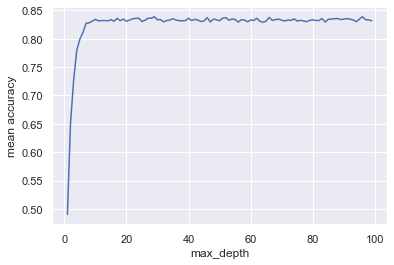

In [93]:
#visualising the result (train_set)
plt.plot(x, result)
plt.xlabel('max_depth')
plt.ylabel('mean accuracy')

In this graph, we can clearly see that as the max depth of the decision tree increases, the performance of the model over the training set increases continuously but after a certain thershold, the accuracy was pretty stagnant. To avoid over-fitting the model, we will take the hyperparameter value which gives the highest accuracy within 0-20 max_depth as this is where the threshold has appeared. <br>
**From the results, we will take max_depth = 11**

### 8.2 n_estimators

In [60]:
rfc = RandomForestRegressor()
x = np.arange(0, 800, 10).tolist()
x = [i for i in x if i != 0] 
parameters = {
    "max_depth":[11],
    "n_estimators": x
}

In [61]:
cv = GridSearchCV(rfc,parameters,cv=5,n_jobs=-1) #use 5-fold cross validation and all processors
cv.fit(train_X,train_Y.values.ravel())

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [11],
                         'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                          100, 110, 120, 130, 140, 150, 160,
                                          170, 180, 190, 200, 210, 220, 230,
                                          240, 250, 260, 270, 280, 290, 300, ...]})

Text(0, 0.5, 'mean accuracy')

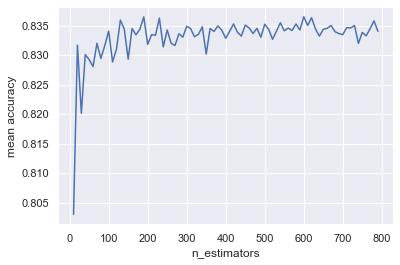

In [63]:
#visualising the result (train_set)
result = cv.cv_results_['mean_test_score']
plt.plot(x, result)
plt.xlabel('n_estimators')
plt.ylabel('mean accuracy')

In [89]:
display(cv)

Best parameters are: {'max_depth': 11, 'n_estimators': 600}


0.803 + or -0.045 for the {'max_depth': 11, 'n_estimators': 10}
0.832 + or -0.041 for the {'max_depth': 11, 'n_estimators': 20}
0.82 + or -0.036 for the {'max_depth': 11, 'n_estimators': 30}
0.83 + or -0.035 for the {'max_depth': 11, 'n_estimators': 40}
0.829 + or -0.039 for the {'max_depth': 11, 'n_estimators': 50}
0.828 + or -0.04 for the {'max_depth': 11, 'n_estimators': 60}
0.832 + or -0.042 for the {'max_depth': 11, 'n_estimators': 70}
0.829 + or -0.04 for the {'max_depth': 11, 'n_estimators': 80}
0.832 + or -0.043 for the {'max_depth': 11, 'n_estimators': 90}
0.834 + or -0.037 for the {'max_depth': 11, 'n_estimators': 100}
0.829 + or -0.04 for the {'max_depth': 11, 'n_estimators': 110}
0.831 + or -0.044 for the {'max_depth': 11, 'n_estimators': 120}
0.836 + or -0.04 for the {'max_depth': 11, 'n_estimators': 130}
0.834 + or -0.041 for the {'max_depth': 11, 'n_estimators': 140}
0.829 + or -0.043 for the {'max_depth': 11,

Although the highest accuracy = 0.837 at n_estimator = 600, a close accuracy of 0.836 is achieved at n_estimator = 130; to avoid over-fitting, we will take **n_estimator = 130**

### 8.3 min_samples_leaf

In [108]:
rfc = RandomForestRegressor()
x = np.arange(0, 100, 1).tolist()
x = [i for i in x if i != 0] 
parameters = {
    "max_depth":[11],
    "n_estimators": [130],
    "min_samples_leaf":x
}

In [109]:
cv = GridSearchCV(rfc,parameters,cv=5,n_jobs=-1) #use 5-fold cross validation and all processors
cv.fit(train_X,train_Y.values.ravel())

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [11],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20, 21, 22, 23, 24, 25, 26, 27,
                                              28, 29, 30, ...],
                         'n_estimators': [130]})

Text(0, 0.5, 'mean accuracy')

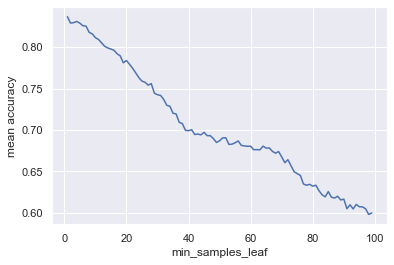

In [110]:
#visualising the result (train_set)
result = cv.cv_results_['mean_test_score']
plt.plot(x, result)
plt.xlabel('min_samples_leaf')
plt.ylabel('mean accuracy')

In [115]:
display_best(cv)

Best parameters are: {'max_depth': 11, 'min_samples_leaf': 1, 'n_estimators': 130}


In this case, we will stick to the default **min_samples_leaf = 1**

### 8.4 min_samples_split

In [135]:
rfc = RandomForestRegressor()
x = np.arange(0, 100, 1).tolist()
x = [i for i in x if i != 0] #accuracy = nan if min_samples_split = 0 or 1 
x = [i for i in x if i != 1]
parameters = {
    "max_depth":[11],
    "n_estimators": [130],
    "min_samples_leaf":[1],
    "min_samples_split":x
}

In [136]:
cv = GridSearchCV(rfc,parameters,cv=5,n_jobs=-1) #use 5-fold cross validation and all processors
cv.fit(train_X,train_Y.values.ravel())

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [11], 'min_samples_leaf': [1],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                               12, 13, 14, 15, 16, 17, 18, 19,
                                               20, 21, 22, 23, 24, 25, 26, 27,
                                               28, 29, 30, 31, ...],
                         'n_estimators': [130]})

Text(0, 0.5, 'mean accuracy')

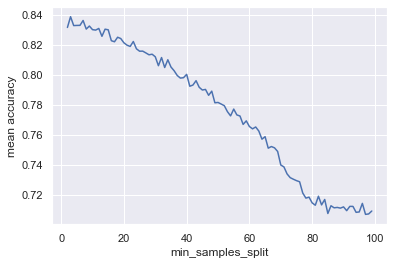

In [137]:
#visualising the result (train_set)
result = cv.cv_results_['mean_test_score']
plt.plot(x, result)
plt.xlabel('min_samples_split')
plt.ylabel('mean accuracy')

In [138]:
display_best(cv)

Best parameters are: {'max_depth': 11, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 130}


In this case, we will take **min_samples_split  = 3**

### 8.5 max_features

In [140]:
rfc = RandomForestRegressor()
x = np.arange(0, 1, 0.1).tolist()
x = [i for i in x if i != 0] 
parameters = {
    "max_depth":[11],
    "n_estimators": [130],
    "min_samples_leaf":[1],
    "min_samples_split":[3],
    "max_features":x
}

In [141]:
cv = GridSearchCV(rfc,parameters,cv=5,n_jobs=-1) #use 5-fold cross validation and all processors
cv.fit(train_X,train_Y.values.ravel())

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [11],
                         'max_features': [0.1, 0.2, 0.30000000000000004, 0.4,
                                          0.5, 0.6000000000000001,
                                          0.7000000000000001, 0.8, 0.9],
                         'min_samples_leaf': [1], 'min_samples_split': [3],
                         'n_estimators': [130]})

In [142]:
display_best(cv)

Best parameters are: {'max_depth': 11, 'max_features': 0.2, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 130}


Text(0, 0.5, 'mean accuracy')

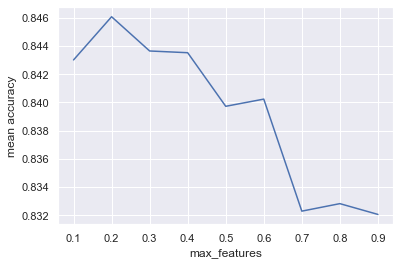

In [143]:
#visualising the result (train_set)
result = cv.cv_results_['mean_test_score']
plt.plot(x, result)
plt.xlabel('max_features')
plt.ylabel('mean accuracy')

The max_features hyperparameter determines what fraction of the original dataset is given to any individual tree. From the result, it is not necessary to give each decision tree of the Random Forest the full data. In this case, we will use **max_features = 0.2**

### 8.6 Putting All Together 

In [434]:
regressor = RandomForestRegressor(max_depth =  11, max_features = 0.2, min_samples_leaf = 1, min_samples_split = 3, n_estimators = 130, random_state = 0)
model = regressor.fit(train_X, train_Y)
y_pred = model.predict(test_X)
train_accuracy_tun = model.score(train_X,train_Y)
test_accuracy_tun = model.score(test_X,test_Y)
print ("Train accuracy =", model.score(train_X,train_Y))
print ("Test accuracy =", model.score(test_X,test_Y))

Train accuracy = 0.9703194689148689
Test accuracy = 0.8386879060942132


In [435]:
#improvement in accuracy
train_improvement = (train_accuracy_tun - train_accuracy)/train_accuracy*100
test_improvement = (test_accuracy_tun - test_accuracy)/test_accuracy*100
print ("Train accuracy improvement =", train_improvement,"%")
print ("Test accuracy improvement =", test_improvement,"%")

Train accuracy improvement = 2.062814193658461 %
Test accuracy improvement = 3.347999552376986 %


The model accuracy has improved after the model hyperparameters have been tuned.

[back to top](#top)

## <a id='section9'>9. Further Data Engineering</a>

### 9.1 Variable Discretisation
Many machine learning algorithms prefer or perform better when numerical with non-standard probability distributions are made discrete. Discretization transforms are a technique for transforming numerical input or output variables to have discrete ordinal labels. <br>

The EqualWidthDiscretiser() sorts the variable values into contiguous intervals of equal size. The size of the interval is calculated as:

( max(X) - min(X) ) / bins

where bins, which is the number of intervals, should be determined by the user. 

In [247]:
x = np.arange(10, 500, 10).tolist() 
train_accuracy_list = []
test_accuracy_list = []
for i in x:
    disc = EqualWidthDiscretiser(bins=i, variables= ['LotArea', 'YearBuilt', 'YearRemodAdd', 
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr','TotRmsAbvGrd', 'Fireplaces', 
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'])
    # fit the transformer
    disc.fit(train_X)

    # transform the data
    train_g= disc.transform(train_X)
    test_g= disc.transform(test_X)
    
    regressor = RandomForestRegressor(n_estimators = 5, random_state = 0)
    model = regressor.fit(train_g, train_Y)
    y_pred = model.predict(test_g)
    train_accuracy_disc = model.score(train_g,train_Y)
    test_accuracy_disc = model.score(test_g,test_Y)
    train_accuracy_list.append(train_accuracy_disc)
    test_accuracy_list.append(test_accuracy_disc)

We have tested how test accuracy varies as we change the number of bins to be used in the variable discretisation of the dataset. From there, we can choose the optimum number of bins to be used. 

Text(0, 0.5, 'accuracy')

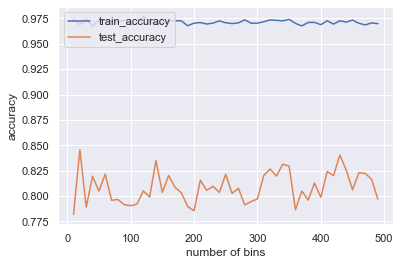

In [439]:
#visualising the result
plt.plot(x, train_accuracy_list, label = "train_accuracy")
plt.plot(x, test_accuracy_list, label = "test_accuracy")
plt.legend(["train_accuracy", "test_accuracy"], loc='upper left')
plt.xlabel('number of bins')
plt.ylabel('accuracy')

In [436]:
#best test_accuracy
max(test_accuracy_list)

0.8456638629896879

In [437]:
test_improvement = (max(test_accuracy_list) - test_accuracy)/test_accuracy*100
print ("Test accuracy improvement compared to the basic model =", test_improvement,"%")

Test accuracy improvement compared to the basic model = 4.207617516189539 %


In [440]:
ind = np.argmax(test_accuracy_list)
bins = x[ind]
print ("The optimum number of bins =", bins)

The optimum number of bins = 20


### 9.2 Missing Data Imputation

From our previous data exploration, these are the variables with null data.

1. LotFrontage /number of null data: 259
2. MasVnrArea /number of null data: 8
3. Electrical /number of null data: 1
4. GarageYrBlt /number of null data: 81

Our previous approach was to remove the null data, what what if we impute the missing data with the mean/median of the variables instead? 

In [651]:
#import the dataset again without previous adjustments
trainn = pd.read_csv('train.csv')

In [652]:
#imputation of continuous variables
median_imputer = MeanMedianImputer(imputation_method='median', variables=['LotFrontage', 'MasVnrArea','GarageYrBlt'])
median_imputer.fit(trainn)
train_t= median_imputer.transform(trainn)

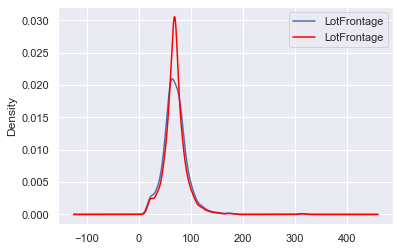

In [653]:
#illustrate an example of difference due to data imputation for variables
fig = plt.figure()
ax = fig.add_subplot(111)
trainn['LotFrontage'].plot(kind='kde', ax=ax)
train_t['LotFrontage'].plot(kind='kde', ax=ax, color='red')
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

In [654]:
#imputation for categorical variables
imputer = CategoricalImputer(variables=['Electrical'])
imputer.fit(train_t) 
train_t1= imputer.transform(train_t)

<AxesSubplot:>

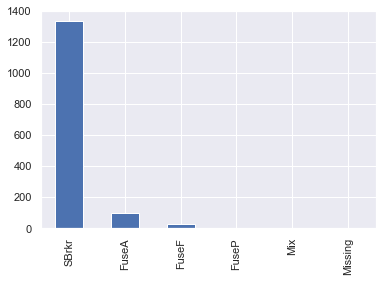

In [655]:
train_t1['Electrical'].value_counts().plot.bar()

In [656]:
#One-Hot encoding
categoricalcolumns = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond','Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
train_t2 = pd.get_dummies(train_t1, columns= categoricalcolumns, prefix= categoricalcolumns)

In [663]:
#train-test split
TEST_SIZE = 0.25

filteredData1 = train_t2.drop(['Id'], axis=1)
train_df, test_df = train_test_split(filteredData1, test_size=TEST_SIZE,shuffle = False) #put shuffle = False so that we can reuse the same training and test sets for better comparison

train_X = train_df.drop('SalePrice', axis=1)
train_Y = train_df['SalePrice']
test_X = test_df.drop('SalePrice', axis=1)
test_Y = test_df['SalePrice']

In [664]:
regressor = RandomForestRegressor(n_estimators = 5, random_state = 0)
model = regressor.fit(train_X, train_Y)
y_pred = model.predict(test_X)
train_accuracy_impute = model.score(train_X,train_Y)
test_accuracy_impute = model.score(test_X,test_Y)
print ("Train accuracy =", model.score(train_X,train_Y))
print ("Test accuracy =", model.score(test_X,test_Y))

Train accuracy = 0.9570011888516992
Test accuracy = 0.8401910962793853


In [665]:
test_improvement = (test_accuracy_impute - test_accuracy)/test_accuracy*100
print ("Test accuracy improvement compared to the basic model =", test_improvement,"%")

Test accuracy improvement compared to the basic model = 3.533231385881989 %


The test accuracy has improved after we have imputed the data instead of just removing the null data.

[back to top](#top)

## <a id='section10'>10. Result Compilation </a>
After all our optimization exploration, we will now consolidate all the effective optimization methods and test it on the Kaggle test set and send the result to Kaggle for calculation of the accuracy score.

In [975]:
models = pd.DataFrame({
    'Optimization Method': [ 'Feature Selection', 'Reducing Skewness in Continuous Variables', 'Reducing Skewness in Categorical Variables','Min-Max Scaling','Z-Standardization','Hyperparameter Tuning','Variable Discretisation','Missing Data Imputation'],
    'Improvement in Test R2 Score (%)': [ 7.29,-2.02, 4.98, 4.98, 5.0, 3.35,4.21,3.53]})

models = models.sort_values(by='Improvement in Test R2 Score (%)', ascending=False)
models.style.hide_index()


Optimization Method,Improvement in Test R2 Score (%)
Feature Selection,7.290000
Z-Standardization,5.000000
Reducing Skewness in Categorical Variables,4.980000
Min-Max Scaling,4.980000
Variable Discretisation,4.210000
Missing Data Imputation,3.530000
Hyperparameter Tuning,3.350000
Reducing Skewness in Continuous Variables,-2.020000


We can see that feature selection is evaluated to be the best optimization method in improving the test R2 score based on our analysis.

### 10.1 Test Data Inspection

In [950]:
test = pd.read_csv('test.csv')
test = test.drop(columns="Id")
test

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


In [477]:
#Inspect the completeness of data (empty data)
def checkemptydata(dataset):
    emptylist= []
    emptylist1 = []
    for i in dataset.columns: 
        emptylist.append(dataset[dataset[i] == ' '].index) 
    for x in emptylist:
        emptylist1.append(len(x))
    if any(emptylist1) == False: 
        print ("The dataset has no empty data")
    else: 
        print ("The dataset contains empty data")   

In [478]:
#check for empty data
checkemptydata(test)

The dataset has no empty data


In [649]:
#Inspect the completeness of data (null data)
def checknulldata(dataset):
    nalist = []
    index = []
    counter = 0
    for i in dataset.columns: 
        nalist.append(dataset[dataset[i].isnull()].index.tolist())
    while counter < len(nalist):
        if len(nalist[counter]) != 0: 
            index.append(counter)
        counter+=1
    if len(index) != 0: 
        for x in index:
            print(dataset.columns[x],"/number of null data:", len(nalist[x])) #return the features which have null data
    else: 
        print("The dataset has no null data")

In [650]:
checknulldata(test)

MSZoning /number of null data: 4
LotFrontage /number of null data: 227
Alley /number of null data: 1352
Utilities /number of null data: 2
Exterior1st /number of null data: 1
Exterior2nd /number of null data: 1
MasVnrType /number of null data: 16
MasVnrArea /number of null data: 15
BsmtQual /number of null data: 44
BsmtCond /number of null data: 45
BsmtExposure /number of null data: 44
BsmtFinType1 /number of null data: 42
BsmtFinSF1 /number of null data: 1
BsmtFinType2 /number of null data: 42
BsmtFinSF2 /number of null data: 1
BsmtUnfSF /number of null data: 1
TotalBsmtSF /number of null data: 1
BsmtFullBath /number of null data: 2
BsmtHalfBath /number of null data: 2
KitchenQual /number of null data: 1
Functional /number of null data: 2
FireplaceQu /number of null data: 730
GarageType /number of null data: 76
GarageYrBlt /number of null data: 78
GarageFinish /number of null data: 78
GarageCars /number of null data: 1
GarageArea /number of null data: 1
GarageQual /number of null data:

From our understanding from data exploration, the true variables with null data are: 
1. LotFrontage /number of null data: 227 (continuous) 
2. MSZoning /number of null data: 4 (categorical)
3. Utilities /number of null data: 2 (categorical)
4. Exterior1st /number of null data: 1 (categorical)
5. Exterior2nd /number of null data: 1 (categorical)
6. MasVnrArea /number of null data: 15 (continuous) 
7. BsmtFinSF1 /number of null data: 1 (continuous) 
8. BsmtFinSF2 /number of null data: 1 (continuous) 
9. BsmtUnfSF /number of null data: 1 (continuous) 
10. TotalBsmtSF /number of null data: 1 (continuous) 
11. BsmtFullBath /number of null data: 2 (continuous) 
12. BsmtHalfBath /number of null data: 2 (continuous) 
13. KitchenQual /number of null data: 1 (categorical) 
14. Functional /number of null data: 2 (categorical) 
15. GarageYrBlt /number of null data: 78 (continuous) 
16. GarageCars /number of null data: 1 (continuous) 
17. GarageArea /number of null data: 1 (continuous) 
18. SaleType /number of null data: 1 (categorical) 

In [529]:
print ("number of variables for train set = ", train.shape[1])
print ("number of variables for test set = ", test.shape[1]) #the datasets have different number of variables

number of variables for train set =  81
number of variables for test set =  80


In [530]:
train_c = train.columns
test_c = test.columns
print ("number of variables in common = ", len(set(train_c).intersection(set(test_c))))
print ("number of variables not in common = ",train.shape[1]-len(set(train_c).intersection(set(test_c))))
#the difference in variables = SalePrice which is what we want to predict

number of variables in common =  80
number of variables not in common =  1


### 10.2 Feature Engineering (Test Set)

In [951]:
#strategy 1 - missing data imputation
median_imputer = MeanMedianImputer(imputation_method='median', variables=['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath','GarageYrBlt','GarageArea','GarageCars'])
median_imputer.fit(test)
test_t= median_imputer.transform(test)

In [952]:
#imputation for categorical variables
imputer = CategoricalImputer(variables=['MSZoning','Utilities','Exterior1st','Exterior2nd','KitchenQual','Functional','SaleType'])
imputer.fit(test_t) 
test_t1= imputer.transform(test_t)

In [953]:
#One-Hot encoding
categoricalcolumns = ['Street',
 'LandContour',
 'Utilities',
 'LandSlope',
 'Condition2',
 'RoofMatl',
 'BsmtCond',
 'Heating',
 'CentralAir',
 'Electrical',
 'Functional',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'MiscFeature','MSSubClass', 'MSZoning', 'Alley', 'LotShape', 'LotConfig', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond','Foundation', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageType', 'GarageFinish', 'PoolQC', 'Fence', 'SaleType', 'SaleCondition']
test_t2 = pd.get_dummies(test_t1, columns= categoricalcolumns, prefix= categoricalcolumns)

### 10.3 Model Training

In [967]:
train = pd.read_csv('train.csv')
train = train.drop(columns="Id")
train

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [955]:
median_imputer = MeanMedianImputer(imputation_method='median', variables=['LotFrontage', 'MasVnrArea','GarageYrBlt'])
median_imputer.fit(trainn)
train_t= median_imputer.transform(trainn)

In [956]:
#imputation for categorical variables
imputer = CategoricalImputer(variables=['Electrical'])
imputer.fit(train_t) 
train_t1= imputer.transform(train_t)

In [957]:
#One-Hot encoding
categoricalcolumns = ['Street',
 'LandContour',
 'Utilities',
 'LandSlope',
 'Condition2',
 'RoofMatl',
 'BsmtCond',
 'Heating',
 'CentralAir',
 'Electrical',
 'Functional',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'MiscFeature','MSSubClass', 'MSZoning', 'Alley', 'LotShape', 'LotConfig', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond','Foundation', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageType', 'GarageFinish', 'PoolQC', 'Fence', 'SaleType', 'SaleCondition']
train_t2 = pd.get_dummies(train_t1, columns= categoricalcolumns, prefix= categoricalcolumns)

In [958]:
X = train_t2.drop(['SalePrice'], axis=1)
Y = train_t2['SalePrice']

In [959]:
features = set(X.columns).intersection(set(test_t2.columns))
features1 = []
for i in features: 
    features1.append(i)

In [966]:
x = X[features1]
regressor = RandomForestRegressor(max_depth =  11, max_features = 0.2, min_samples_leaf = 1, min_samples_split = 3, n_estimators = 130, random_state = 0)
model = regressor.fit(x, Y)
print ("Train accuracy =", model.score(x,Y))

Train accuracy = 0.9724799691383366


### 10.4 Test Results

In [961]:
test_t2 = test_t2[features1]
y_pred = model.predict(test_t2)

In [962]:
# Convert predictions to dataframe
submission_predictions_df = pd.DataFrame(y_pred, columns=["SalePrice"])
print(submission_predictions_df)

      SalePrice
0      133530.0
1      157090.0
2      188340.0
3      203500.0
4      191614.0
...         ...
1454    86540.0
1455    89490.0
1456   144115.9
1457   108870.0
1458   198920.0

[1459 rows x 1 columns]


In [963]:
# Get ids from test.csv
submission_df = pd.read_csv("./test.csv")
submission_df = submission_df["Id"]
submission_df.head()

0    1461
1    1462
2    1463
3    1464
4    1465
Name: Id, dtype: int64

In [964]:
# Join building ids with predictions
result = pd.concat([submission_df, submission_predictions_df], axis=1, sort=False)
result.set_index('Id', inplace=True)
result.head()

,SalePrice
Id,
1461,133530.0
1462,157090.0
1463,188340.0
1464,203500.0
1465,191614.0


In [965]:
result.to_csv('/Users/leawangyi/Documents/2021/DOCUMENTS/REP Y3S2/CE9010-INTRODUCTION TO DATA ANALYSIS/Group Project/result6.csv',index = True)

### Final Result 
We have performed several rounds of trials and errors, as Kaggle allows us to submit multiple submissions for the best score. In our trials, we have readjusted such that only the most effective optimization methods were used to predict on the Kaggle test set.  <br>
After a few trials, we have attained the **best RMSE logarithmic error score of 0.15423 after our submission on Kaggle**

[back to top](#top)